In [1]:
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

data = data[:, 1:]

data_norm = data / np.max(data)

data_tensor = torch.FloatTensor(data_norm)

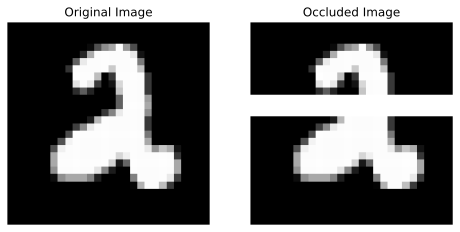

In [3]:
img = data_tensor[1234,:].view(28, 28)

occluded = copy.deepcopy(img)
occluded[10:13, :] = 1

_, axis = plt.subplots(1, 2, figsize=(8, 6))

axis[0].imshow(img, cmap="gray")
axis[0].set_title("Original Image")
axis[0].axis("off")

axis[1].imshow(occluded, cmap="gray")
axis[1].set_title("Occluded Image")
axis[1].axis("off");

In [4]:
def create_autoencoders():

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 150)
            self.enc = nn.Linear(150, 50)
            self.code = nn.Linear(50, 150)
            self.dec = nn.Linear(150, 784)

        def forward(self, x):
            x = f.relu(self.input(x))
            x = f.relu(self.enc(x))
            x = f.relu(self.code(x))
            return torch.sigmoid(self.dec(x))

    model = Model()

    loss_fun = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    return model, loss_fun, optimizer

In [5]:
def train_model():
    num_epochs = 5

    model, loss_fun, optimizer = create_autoencoders()

    losses = []

    batch_size  = 32
    num_batches = int(data_tensor.shape[0]/batch_size)

    for epoch_i in range(num_epochs):

        rand_idx = np.random.permutation(data_tensor.shape[0]).astype(int)

        for batch_i in range(num_batches):

            sample = range((batch_i-1)*batch_size, batch_i*batch_size)
            
            x = data_tensor[rand_idx[sample],:]

            y_hat = model(x)
            loss = loss_fun(y_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

    return losses, model

Final Loss: 0.01


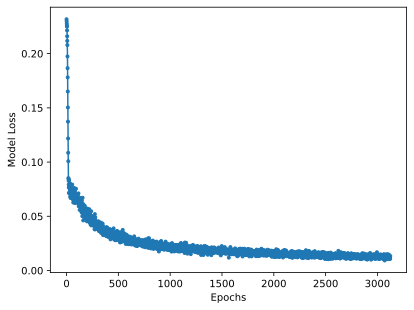

In [6]:
losses, model = train_model()

print(f"Final Loss: {losses[-1]:0.2f}")

plt.plot(losses, ".-")
plt.xlabel("Epochs")
plt.ylabel("Model Loss");

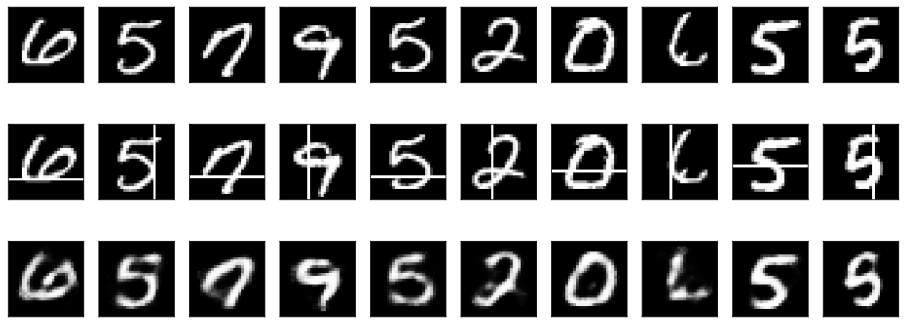

In [7]:
x = copy.deepcopy(data_tensor[:10, :])

for i in range(x.shape[0]):
    img = x[i, :].view(28, 28)
    
    start_loc = np.random.choice(range(10, 21))
    
    if i%2 == 0:
        img[start_loc:start_loc+1, :] = 1
    else:
        img[:, start_loc:start_loc+1] = 1
        

de_occluded = model(x)

_, axis = plt.subplots(3, 10, figsize=(16, 6))

for i in range(10):
    axis[0,i].imshow(data_tensor[i,:].view(28,28).detach() ,cmap='gray')
    axis[1,i].imshow(x[i,:].view(28,28).detach() ,cmap='gray')
    axis[2,i].imshow(de_occluded[i,:].view(28,28).detach() ,cmap='gray')
    axis[0,i].set_xticks([]), axis[0,i].set_yticks([])
    axis[1,i].set_xticks([]), axis[1,i].set_yticks([])
    axis[2,i].set_xticks([]), axis[2,i].set_yticks([])

plt.show()

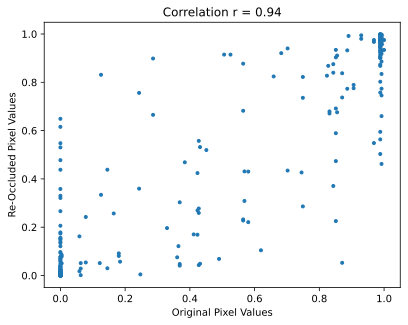

In [8]:
in_out_corr = np.corrcoef(data_tensor[9, :].detach(), de_occluded[9, :].detach())

plt.plot(data_tensor[9, :].detach(), de_occluded[9, :].detach(), '.')
plt.xlabel("Original Pixel Values")
plt.ylabel("Re-Occluded Pixel Values")
plt.title(f"Correlation r = {in_out_corr[0, 1]:0.2f}");

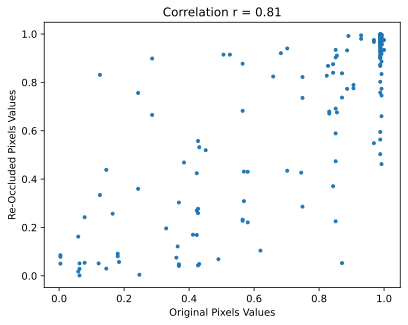

In [9]:
original = data_tensor[9, :].detach()
re_occluded = de_occluded[9, :].detach()

tolerance = 1e-4
non_zero_pixels = (original>tolerance)&(re_occluded>tolerance)

in_out_corr = np.corrcoef(original[non_zero_pixels], re_occluded[non_zero_pixels])

plt.plot(original[non_zero_pixels], re_occluded[non_zero_pixels], '.')
plt.xlabel("Original Pixels Values")
plt.ylabel("Re-Occluded Pixels Values")
plt.title(f"Correlation r = {in_out_corr[0, 1]:0.2f}");